<font color='blue'> Привет. Поздравляю с первым сборным проектом. Ниже мои комментарии выделены синим. </font>

## Анализ игровых продуктов

-  [Шаг 1. Ознакомимся с данными](#1)
-  [Шаг 2. Подготовка данных](#2)
-  [Шаг 3. Исследовательский анализ данных](#3)
-  [Шаг 4. Портрет пользователя каждого региона](#4)
-  [Шаг 5. Проверка гипотез](#5)
-  [Шаг 6. Общий вывод](#6)

### Описание проекта
Из открытых источников доступны исторические данные (до 2016 года) о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Необходимо выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании для интернет-магазина на 2017 год.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats


### <a name="1">Шаг 1. Ознакомимся с данными.</a>

Путь к файлу:

`/datasets/games.csv`

In [2]:
games = pd.read_csv('/datasets/games.csv')

In [3]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [4]:
games.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [5]:
games[games['Name'].isnull()]

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


In [6]:
games['User_Score'].value_counts()

tbd    2424
7.8     324
8       290
8.2     282
8.3     254
       ... 
1.3       2
0.3       2
9.6       2
9.7       1
0         1
Name: User_Score, Length: 96, dtype: int64

<font color='blue'> Здесь полезно было бы описать просмотренные данные. Где есть пропуски, их природа и несоответствие типов. а также предположить путь решения - т.е. составить план на предобоработку. </font>

### <a name="1">Шаг 2. Подготовка данных </a>

- [Заменим названия столбцов (приведем к нижнему регистру)](#2.1)
- [Преобразуем данные в нужные типы](#2.2)
- [Обработаем пропуски](#2.3)
- [Посчитаем суммарные продажи во всех регионах и запишем их в отдельный столбец](#2.4)

<a name="2.1">Приведем названия столбцов к нижнему регистру:</a>

In [7]:
columns = games.columns.to_series().str.lower()
games.set_axis(columns, axis = 'columns', inplace = True)

In [8]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16715 non-null object
year_of_release    16446 non-null float64
genre              16713 non-null object
na_sales           16715 non-null float64
eu_sales           16715 non-null float64
jp_sales           16715 non-null float64
other_sales        16715 non-null float64
critic_score       8137 non-null float64
user_score         10014 non-null object
rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


<font color='blue'> Хорошо. </font>

<a name="2.2">Преобразуем данные в нужные типы.</a>

 Опишите, в каких столбцах заменили тип данных и почему;
 - тип данных в столбце `year_of_release` заменим на `int`, так как значения в данном столбце могут быть только целые (пустые значения заменим на 0)
 - тип данных в столбце `user_score` заменим на `float64`

In [9]:
games['year_of_release'] = games['year_of_release'].fillna(0)
games['year_of_release'] = games['year_of_release'].astype('int')

In [10]:
games.loc[(~games.loc[:,'user_score'].isnull())&
          (games.loc[:,'user_score'] != 'tbd'),
          'user_score'] = games.loc[(~games.loc[:,'user_score'].isnull())&
                                    (games.loc[:,'user_score'] != 'tbd'),
                                    'user_score'].astype('float64')

 <a name="2.3">Обработаем пропуски: </a>
 -  в столбцах с информацией о названии, жанре и рейтинге ESRB вместо пропусков укажем, что информация неизвестна: 
    -  Информация о названии и жанре отсутствует в одних и тех же двух строках, это некие игры, о которых известна лишь платформа, год релиза и продажи. Это может быть даже одна и та же игра - так как в одной из строк есть продажи по Америке, Европе и другим странам, а в другой - только по Японии. Но точно утверждать это нельзя, и в целом эти две строки без оценок нужны ли?????
    -  Информация о рейтинге ESRB отсутствует по части игр - проверить по производителям и продажам - возможно есть связь. Рейтинг ESRB - американская система возрастной классификации для игр, основанная в 1994 году, соответственно, игры, произведенные ранее, не имеют соответствующей классификации. Таких игр нашлось 451. Есть также 88 игр без рейтинга, у которых не известна дата релиза, то есть теоретически они могли быть выпущены до 94 года. И есть всего 4 игры, выпущенные до 94 года, но получившие рейтинг ESRB.  Кроме того, по информации с официального сайта, эта классификация является добровольной, то есть не обязательной, поэтому те производители, кто не хотел классифицировать свои продукты, могли этого не делать.  Помимо этого, в Европе, Австралии, России существуют свои системы, и материалам, производимым в этих регионах, могут не присваиваться рейтинги ESRB.
 - Обращает на себя внимание аббревиатура 'tbd' в столбцах с рейтингом. Заменим их на NaN, так как по сути информации о рейтинге в этих случаях отсутствует
 -  в столбцах с рейтингами критиков и пользователей заполнять пропуски не будем - заменять их на 0 или среднее неправильно, а оставить там NaN удобно для дальнейшей работы с этими столбцами. Причиной пропусков может быть то, что данные брались из разных источников. Хотя чаще всего если оценки есть, они обе присутствуют. 


<font color='blue'> Хорошо, только надо понимать, что замена на 0 = удаление в данном случае. Т.к весь анализ будет вестись в разрезе годов релиза. </font>

Есть ли игры, произведенные до 1994 года и не имеющие рейтинг ESRB?

In [12]:
games.loc[games['rating'].isnull(),'rating'] = np.nan
len(games[games['rating'].isna()&(games['year_of_release'] < 1994)])     

451

Есть ли игры с неизвестной датой релиза, не имеющие рейтинг ESRB? 

In [13]:
len(games[games['rating'].isna()&
          (games['year_of_release'] == 0)])

88

Есть ли игры, произведенные до 1994 года, но имеющие рейтинг ESRB? 

In [14]:
len(games[~games['rating'].isna()&
          (games['year_of_release'] < 1994)&
          (games['year_of_release'] != 0)])

4

Сколько игр, выпущенных после 94 года, не имеют рейтинг ESRB?

In [15]:
len(games[games['rating'].isna()&
          (games['year_of_release'] >= 1994)])

6315

Для сравнения - количество игр, выпущенных после 94 года и имеющих рейтинг ESRB:

In [16]:
len(games[~games['rating'].isna()&
          (games['year_of_release'] >= 1994)])

9764

На гистограмме ниже можно видеть, как распределились игры с рейтингом ESRB по году выпуска:

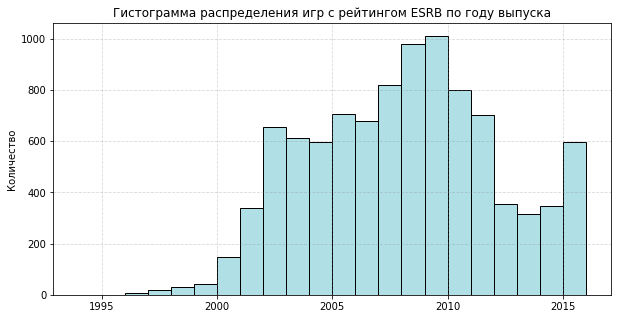

In [17]:
plt.figure(figsize=(10, 5))
plt.hist(games[~games['rating'].isna()&
               (games['year_of_release']>=1994)]['year_of_release'],
         bins=22,ec='black', alpha = 1, color='powderblue')
plt.grid(True, linestyle='--', color='grey', alpha=.3)
plt.title('Гистограмма распределения игр с рейтингом ESRB по году выпуска')
plt.xlabel('')
plt.ylabel('Количество')
plt.show()


Пик пришелся на 2008-2009 года. Возможно, это связано с ростом индустрии в этот период. Проверим, есть ли пик в этот период у игр без рейтинга:

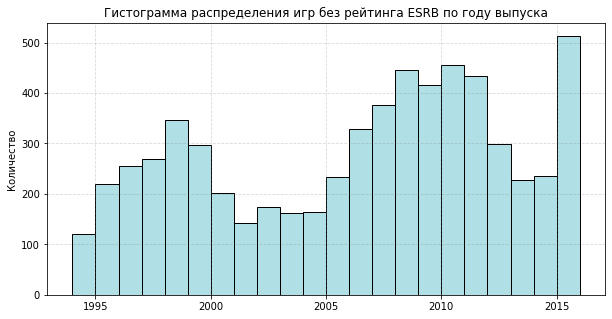

In [18]:
plt.figure(figsize=(10, 5))
plt.hist(games[games['rating'].isna()&
               (games['year_of_release']>=1994)]['year_of_release'], 
         bins=22,ec='black', alpha = 1, color='powderblue')
plt.grid(True, linestyle='--', color='grey', alpha=.3)
plt.title('Гистограмма распределения игр без рейтинга ESRB по году выпуска')
plt.xlabel('')
plt.ylabel('Количество')
plt.show()


Игры продолжали выходить в сравнимом объеме после 2010 года, однако рейтинговались уже не так активно.
В 2016 году случился еще один пик - вышло в 2 раза больше игр, чем в 2015, соответственно, и рейтингованных игр стало больше.

Обращает на себя внимание аббревиатура 'tbd' в столбцах с рейтингом. Что бы это ни значило - 'to be determined' или 'to be decided', в столбце с рейтингом это сокращение не информативно. Заменим их на NaN.

In [19]:
print('Количество строк с аббревиатурой вместо рейтинга:', len(games[games['user_score'] == 'tbd']))

Количество строк с аббревиатурой вместо рейтинга: 2424


In [20]:
games.loc[games['user_score'] == 'tbd', 'user_score'] = np.nan

Как соотносятся выборки без оценки пользователей и без оценки критиков? Эти выборки частично пересекаются.

In [109]:
print('Объем выборки без оценки пользователей и критиков', 
      len(games[(games['user_score'].isna())&
                (games['critic_score'].isna())]), 'строк')
print('Объем выборки без оценки пользователей, но с оценкой критиков',
      len(games[(games['user_score'].isna())&(~games['critic_score'].isna())]), 'строк')
print('Объем выборки с оценкой пользователей, но без оценки критиков',
      len(games[(~games['user_score'].isna())&(games['critic_score'].isna())]), 'строк')
print('Объем выборки и с оценками пользователей, и с оценками критиков', 
      len(games[(~games['user_score'].isna())&
                (~games['critic_score'].isna())]), 'строк')

Объем выборки без оценки пользователей и критиков 8005 строк
Объем выборки без оценки пользователей, но с оценкой критиков 1120 строк
Объем выборки с оценкой пользователей, но без оценки критиков 573 строк
Объем выборки и с оценками пользователей, и с оценками критиков 7017 строк


В случае пропусков в названии, жанре или рейтинге игры укажем, что информация неизвестна.

In [110]:
games.loc[games.loc[:,'name'].isnull(),'name'] = 'Unknown'
games.loc[games.loc[:,'genre'].isnull(),'genre'] = 'Unknown'
games.loc[games.loc[:,'rating'].isnull(),'rating'] = 'Unknown'

<font color='blue'> Ок, отличная обработка. </font>

 <a name="2.4">Посчитаем суммарные продажи во всех регионах и запишем их в отдельный столбец</a>

In [111]:
games['total_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']

<font color='blue'> Целевой параметр рассчитан верно, можно переходить к анализу. </font>

### <a name="3">Шаг 3. Исследовательский анализ данных</a>

- [Посмотрим, сколько игр выпускалось в разные годы.](#3.1)
- [Посмотрим, как менялись продажи по платформам.](#3.2) 
- [Возьмем данные за соответствующий актуальный период.](#3.3)
- [Выберем несколько потенциально прибыльных платформ.](#3.4)
- [Построим график «ящик с усами» по глобальным продажам каждой игры и разбивкой по платформам.](#3.5)
- [Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков.](#3.6) 
- [Соотнесем выводы с продажами игр на других платформах.](#3.7)
- [Посмотрим на общее распределение игр по жанрам.](#3.8)

#### <a name="3.1">Посмотрим, сколько игр выпускалось в разные годы.</a>

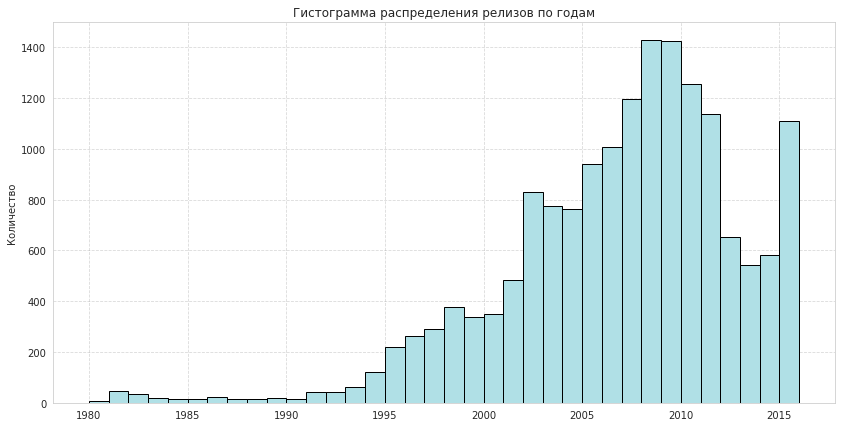

In [112]:
plt.figure(figsize=(14, 7))
plt.hist(games[games['year_of_release']>0]['year_of_release'], bins=36, 
         ec='black', alpha = 1, color='powderblue')
plt.grid(True, linestyle='--', color='grey', alpha=.3)
plt.title('Гистограмма распределения релизов по годам')
plt.xlabel('')
plt.ylabel('Количество')
plt.show()

<font color='blue'> Все здорово. Вот видишь 0 сразу удалили из рассмотрения. </font>

Можно также глянуть, как в целом ведут себя продажи по годам:

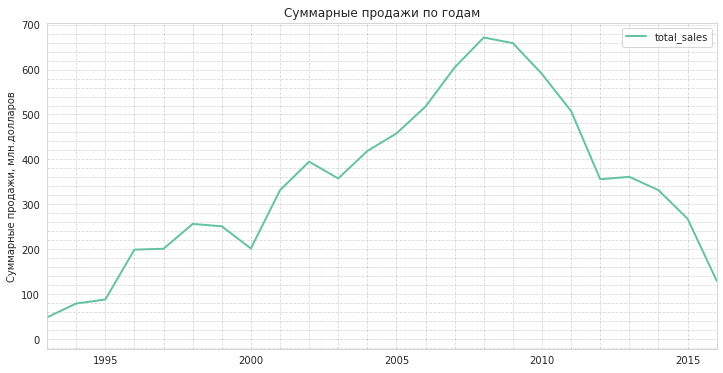

In [198]:
sales = games[(games['year_of_release'] != 0)].pivot_table(values = 'total_sales', 
                                                           index = 'year_of_release',
                                                           aggfunc = 'sum')
sales.plot(figsize=(12, 6), lw=2, alpha=1, cmap="Set2")
plt.minorticks_on()
plt.grid(linestyle='--', which='major',
         color='grey', alpha=.3)
plt.grid(which='minor', 
        color = 'grey', 
        linestyle = '--', alpha=.3)
plt.title('Суммарные продажи по годам')
plt.ylabel('Суммарные продажи, млн.долларов')
plt.xlabel('')
plt.xlim(1993, 2016)
plt.legend()
plt.show()

Кажется, пик популярности пройден в 2008-2009 годах. С тех пор рынок падает, тренд на снижение весьма однозначный.

<font color='blue'> Хорошо. </font>

#### <a name="3.2">Посмотрим, как менялись продажи по платформам. </a>

Выберем платформы с наибольшими суммарными продажами:

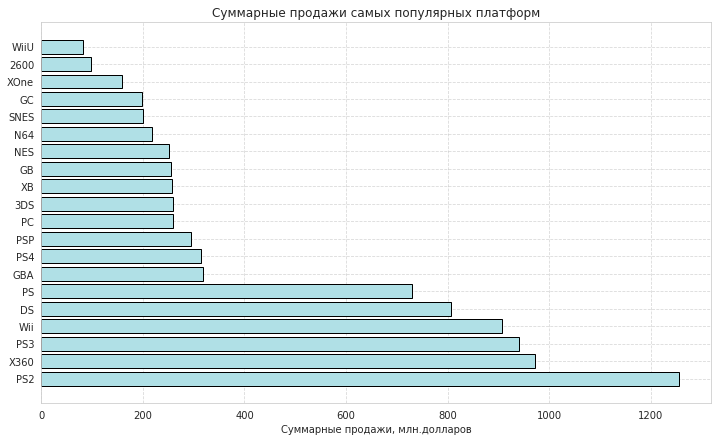

In [113]:
plt.figure(figsize=(12, 7))
platforms_sales = games.pivot_table('total_sales', 
                                    index = 'platform', 
                                    aggfunc = 'sum').sort_values(by = 'total_sales', 
                                                                 ascending = False).head(20)

platforms_names = pd.DataFrame(data=platforms_sales).reset_index()
plt.barh(platforms_names['platform'], platforms_names['total_sales'], 
         ec='black', alpha = 1, color='powderblue')
plt.grid(True, linestyle='--', 
                   color='grey', alpha=.3)
plt.title('Суммарные продажи самых популярных платформ')
plt.xlabel('Суммарные продажи, млн.долларов')
plt.show()
# выделим топ-6 платформ
top_6 = platforms_names['platform'].head(6)

Построим распределение суммарных продаж по годам по каждой из популярных платформ. Выясним, за какой характерный срок появляются новые и исчезают старые платформы.

<font color='blue'> Платформы выделены верно. </font>

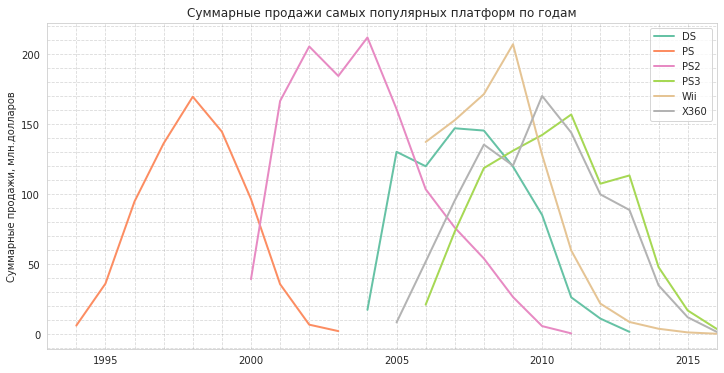

In [114]:
sales_dynamics = games[(games['year_of_release'] != 0)&
                       (games['platform'].isin(top_6))].pivot_table(values = 'total_sales', 
                                                                    index = 'year_of_release',
                                                                    columns = 'platform', 
                                                                    aggfunc = 'sum')

sales_dynamics.plot(figsize=(12, 6), lw=2, alpha=1, cmap="Set2")
plt.minorticks_on()
plt.grid(linestyle='--', which='major',
         color='grey', alpha=.3)
plt.grid(which='minor', 
        color = 'grey', 
        linestyle = '--', alpha=.3)
plt.title('Суммарные продажи самых популярных платформ по годам')
plt.ylabel('Суммарные продажи, млн.долларов')
plt.xlabel('')
plt.xlim(1993, 2016)
plt.legend()
plt.show()

В среднем жизненный цикл платформы составляет ~10 лет. Пики продаж приходятся на 4-6 года существования платформы. После выхода обновленной версии платформы продажи старой версии постепенно снижаются.

<font color='blue'> Да, все верно. </font>

Проверим, является ли динамика релизов показателем, который может предсказывать динамику продаж с опережением:

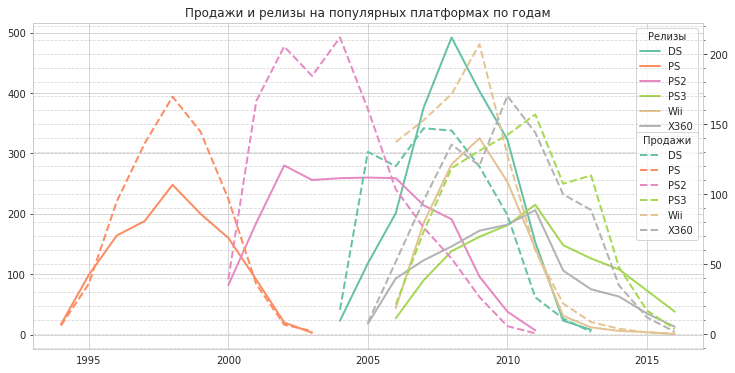

In [115]:
games_dynamics = games[(games['year_of_release'] != 0)&
                       games['platform'].isin(top_6)].pivot_table(values = 'name', 
                                                                  index = 'year_of_release',
                                                                  columns = 'platform', 
                                                                  aggfunc = 'count')


ax1 = games_dynamics.plot(figsize=(12, 6), lw=2, alpha=1, cmap="Set2")
ax2 = ax1.twinx()
sales_dynamics.plot(figsize=(12, 6), lw=2, alpha=1, cmap="Set2", ax=ax2, linestyle='--')

plt.minorticks_on()
plt.grid(linestyle='--', which='major',
         color='grey', alpha=.3)
plt.grid(which='minor', 
        color = 'grey', 
        linestyle = '--', alpha=.3)
plt.title('Продажи и релизы на популярных платформах по годам')
ax1.set_ylabel('')
ax1.set_xlabel('')
plt.xlim(1993, 2017)
ax1.legend(title='Релизы', loc='upper right')
ax2.legend(title='Продажи', loc='center right')

plt.show()

Гипотеза не подтвердилась. Зато видна логичная корелляция!
Мы могли наблюдать ранее, как после выхода обновленной версии платформы продажи старой версии постепенно снижаются. Интересно, что даже после выхода новой версии платформы какое-то время продолжается выпуск новых игр на старой платформе, то есть жизненный цикл не прерывается резко с выходом обновленной платформы, а постепенно завершается. Вероятно, прежде всего это связано с техническими требованиями вновь выходящих игр - старые платформы уже не могут им удовлетворять, поэтому для старой платформы выходит все меньше игр, и продажи неизбежно падают.

#### <a name="3"> Возьмем данные за соответствующий актуальный период.</a>  

Актуальный период равняется 10 годам, как мы выяснили ранее. 

In [116]:
games_relevant = games[games['year_of_release'] >= 2006]

<font color='blue'> Здесь период выбран великоват. Ты же сама писала, что пик приходится на 4-6 лет, нам же интересны именно растущие платформы. Т.е надо было рассматривать примерно с 2012 года. </font>

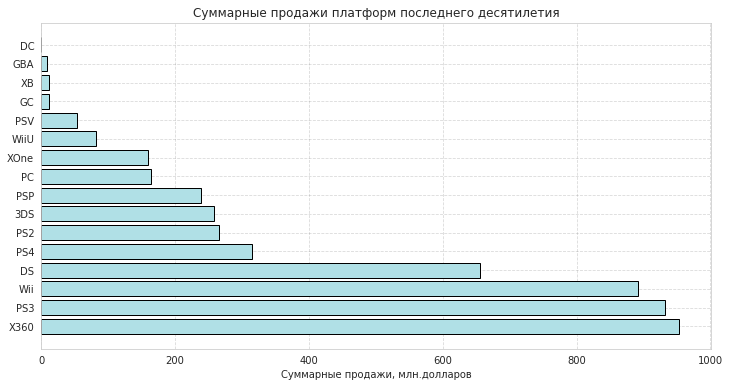

In [117]:
plt.figure(figsize=(12, 6))
relevant_platforms_sales = games_relevant.pivot_table('total_sales', 
                                    index = 'platform', 
                                    aggfunc = 'sum').sort_values(by = 'total_sales', 
                                                                 ascending = False)

relevant_platforms = pd.DataFrame(data=relevant_platforms_sales).reset_index()
plt.barh(relevant_platforms['platform'], relevant_platforms['total_sales'], 
         ec='black', alpha = 1, color='powderblue')
plt.grid(True, linestyle='--', 
                   color='grey', alpha=.3)
plt.title('Суммарные продажи платформ последнего десятилетия')
plt.xlabel('Суммарные продажи, млн.долларов')
plt.show()


Рассмотрим платформы с самыми низкими продажами за последнюю декаду. Это потерявшие актуальность продукты или совсем новые, еще набирающие популярность?

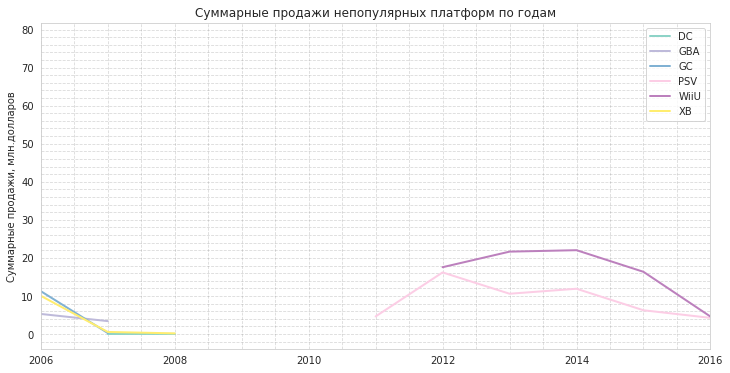

In [118]:
tail = relevant_platforms.tail(6)
tail_sales = games[games['platform'].
                   isin(tail['platform'])].pivot_table('total_sales', 
                                                       columns = 'platform', 
                                                       index ='year_of_release',
                                                       aggfunc = 'sum')
tail_sales.plot(figsize=(12, 6), lw=2, alpha=1, cmap="Set3")
plt.minorticks_on()
plt.grid(linestyle='--', which='major',
         color='grey', alpha=.3)
plt.grid(which='minor', 
        color = 'grey', 
        linestyle = '--', alpha=.3)
plt.title('Суммарные продажи непопулярных платформ по годам')
plt.ylabel('Суммарные продажи, млн.долларов')
plt.xlabel('')
plt.xlim(2006, 2016)
plt.legend()
plt.show()

Из относительно новых - платформы PSV и WiiU. Хотя их жизненный цикл не составил пока 10 лет, но не похоже, что эти платформы станут популярнее, чем ранее, поэтому можно исключить из дальнейшего рассмотрения все платформы с низкими продажами.

#### <a name="3.4">Выберем несколько потенциально прибыльных платформ.</a> 

Выясним, какие платформы лидируют по продажам, растут или падают:

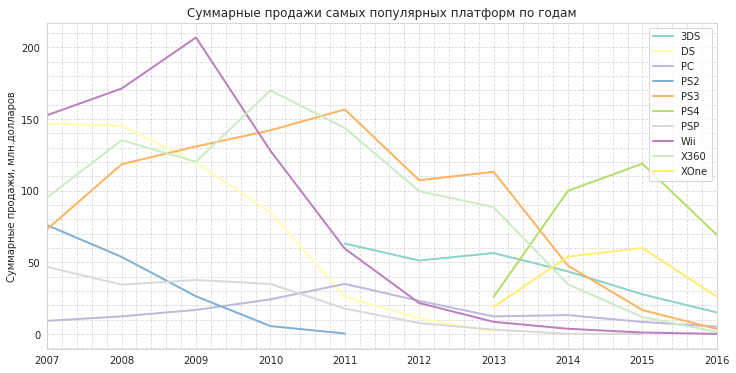

In [119]:
# выделим топ-10 платформ
top_10_relevant = relevant_platforms['platform'].head(10)

relevant_sales_dynamics = games_relevant[(games_relevant
                                          ['year_of_release']!=0)&
                                         games_relevant['platform'].
                                         isin(top_10_relevant)].pivot_table(values = 
                                                                            'total_sales', 
                                                                            index = 
                                                                            'year_of_release',
                                                                            columns = 
                                                                            'platform', 
                                                                            aggfunc = 'sum')

relevant_sales_dynamics.plot(figsize=(12, 6), lw=2, alpha=1, cmap="Set3")
plt.minorticks_on()
plt.grid(linestyle='--', which='major',
         color='grey', alpha=.3)
plt.grid(which='minor', 
        color = 'grey', 
        linestyle = '--', alpha=.3)
plt.title('Суммарные продажи самых популярных платформ по годам')
plt.ylabel('Суммарные продажи, млн.долларов')
plt.xlabel('')
plt.xlim(2007, 2016)
plt.legend()
plt.show()

- На конец 2016 года лидировали по продажам платформы **XOne** и  **PS4**. Похоже, пики популярности эти платформы уже пережили, но все еще будут актуальны какое-то время. 
- Консоль 3DS, выпущенная в 2011 году, все еще продается, но постепенно теряет популярность, и продажи постепенно снижаются. 
- Заканчивается жизненный цикл платформ DS, PSP, PS2, PS3, X360 и Wii, продажи по ним стремительно снизились. 
- Относительно стабильные (медленно снижающиеся) продажи у платформы PC. 

<font color='blue'> Хорошо, платформы выбраны верно. </font>

#### <a name="3.5"> Построим график «ящик с усами» по глобальным продажам каждой игры.</a> 

In [120]:
games_platforms = games_relevant.pivot_table('total_sales', 
                                             index='name', 
                                             columns='platform', aggfunc='sum')
games_platforms.fillna(0, inplace=True)
games_platforms['all_platforms'] = games_platforms.sum(axis=1)
games_platforms = games_platforms.sort_values(by='all_platforms', ascending=False)
games_platforms = games_platforms.reset_index()

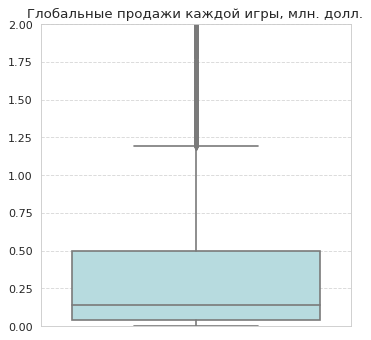

In [121]:
plt.figure(figsize=(5, 5), dpi= 80)
plt.ylim(0,2)
plt.title('Глобальные продажи каждой игры, млн. долл.')

plt.grid(linestyle='--', which='major',
         color='grey', alpha=.3)
sns.boxplot(y=games_platforms['all_platforms'], color="powderblue")
plt.ylabel('')
plt.show()

Чаще всего продажи игр на всех платформах не превышают 1.2 млн. долларов. Хотя есть много бестселлеров, которые могут иметь продажи в десятки млн долларов.

"Ящики с усами" по глобальным продажам с разбивкой по платформам:

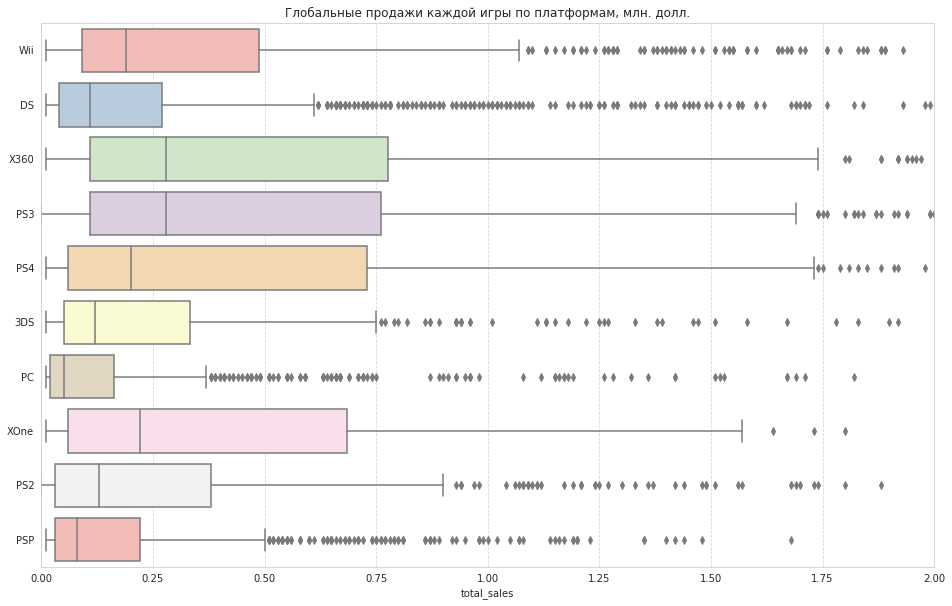

In [183]:
plt.figure(figsize=(16, 10))
plt.xlim(0,2)
plt.title('Глобальные продажи каждой игры по платформам, млн. долл.')

plt.grid(linestyle='--', which='major',
         color='grey', alpha=.3)

sns.boxplot(y = 'platform', x = 'total_sales',
            data = games_relevant[games_relevant['platform'].isin(top_10_relevant)],
            orient="h",
           palette = 'Pastel1')
plt.ylabel('')
plt.show()

In [123]:
games_relevant.groupby(['platform']).sum()['total_sales'].sort_values(ascending=False)

platform
X360    952.99
PS3     931.34
Wii     891.18
DS      655.35
PS4     314.14
PS2     265.80
3DS     257.81
PSP     238.63
PC      163.42
XOne    159.32
WiiU     82.19
PSV      53.81
GC       11.53
XB       10.77
GBA       8.68
DC        0.06
Name: total_sales, dtype: float64

- Основная масса игр, выходящих на X360, PS3, PS4 и XOne, успешна в продажах. [Далее](#ссыль) мы будем смотреть, игры для каких платформ больше любят критики, и увидим связь с продажами. 
- При этом игры для платформы Wii, несмотря на то, что по глобальным продажам эта платформа на третьем месте (объясняется тем что консоль появилась довольно давно - в 2006 году, как и PS3), чаще менее успешны, чем игры для  X360, XOne, PS3 и PS4. Критики меньше любят игры для этой консоли, стоят они в среднем меньше, и рандомная игра для этой консоли с меньшей вероятностью принесет большие продажи, нежели в случае с какой-то другой популярной платформой.
- Та же примерно ситуация с консолью DS, которая также вышла давно, благодаря чему сделала хорошие продажи (четвертая в рейтинге общих продаж за последние 10 лет). Однако выходившие игры в основной массе были менее прибыльны, чем в случае других популярных платформ.

<font color='blue'> Отлично, ящики с усами сделаны верно. </font>

#### <a name="3.6"> Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. </a>   

Выберем популярную платформу с максимальными продажами - X360. Построим для нее диаграммы рассеяния:

In [124]:
X360_relevant = games_relevant[(games_relevant['platform'] == 'X360')&
                               (~games_relevant['critic_score'].isna())&
                               (~games_relevant['user_score'].
                                isna())].reset_index(drop=True).copy()
X360_relevant.loc[:,'user_score'] = X360_relevant.loc[:,'user_score'].astype('float64')

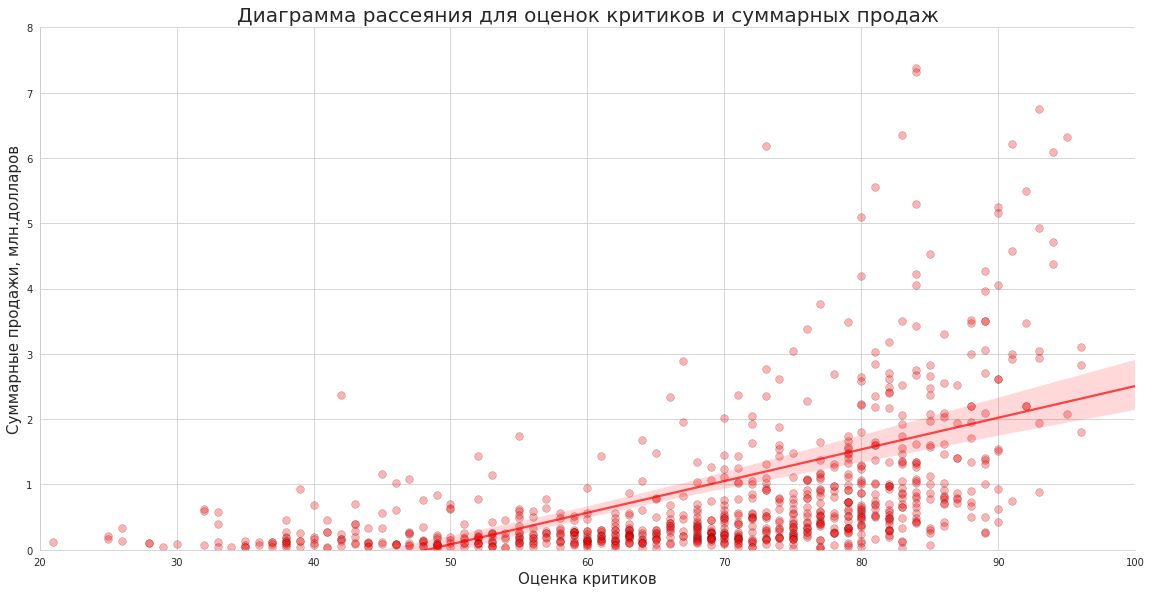

In [125]:
sns.set_style("whitegrid")
ax = sns.lmplot('critic_score','total_sales',data=X360_relevant, 
                height=8, aspect=2,
                scatter_kws=dict(s=60, linewidths=.5, color='r', 
                                 edgecolors='black', alpha=0.3),
                line_kws=dict(color='r', alpha=0.7))


ax.set(xlim=(20, 100), ylim=(0, 8))
plt.title("Диаграмма рассеяния для оценок критиков и суммарных продаж", fontsize=20)
plt.ylabel('Суммарные продажи, млн.долларов', fontsize=15)
plt.xlabel('Оценка критиков', fontsize=15)
plt.show()

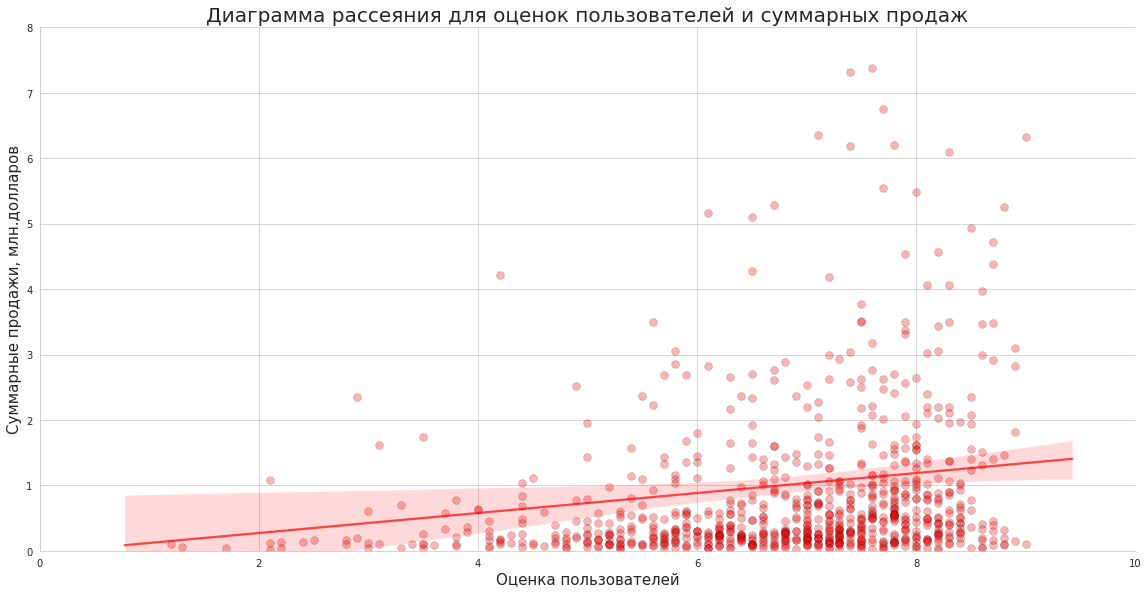

In [126]:
sns.set_style("whitegrid")
ax = sns.lmplot('user_score','total_sales',data=X360_relevant, 
                height=8, aspect=2,
                scatter_kws=dict(s=60, linewidths=.5, color='r', 
                                 edgecolors='black', alpha=0.3),
                line_kws=dict(color='r', alpha=0.7))


ax.set(xlim=(0, 10), ylim=(0, 8))
plt.title("Диаграмма рассеяния для оценок пользователей и суммарных продаж", fontsize=20)
plt.ylabel('Суммарные продажи, млн.долларов', fontsize=15)
plt.xlabel('Оценка пользователей', fontsize=15)
plt.show()

Оценка критиков и суммарные продажи показывают зависимость: в случае, если оценка критиков больше 50, продажи в среднем выше, если выше оценка критиков.

Посмотрим также, есть ли зависимость между оценками критиков и оценками пользователей:

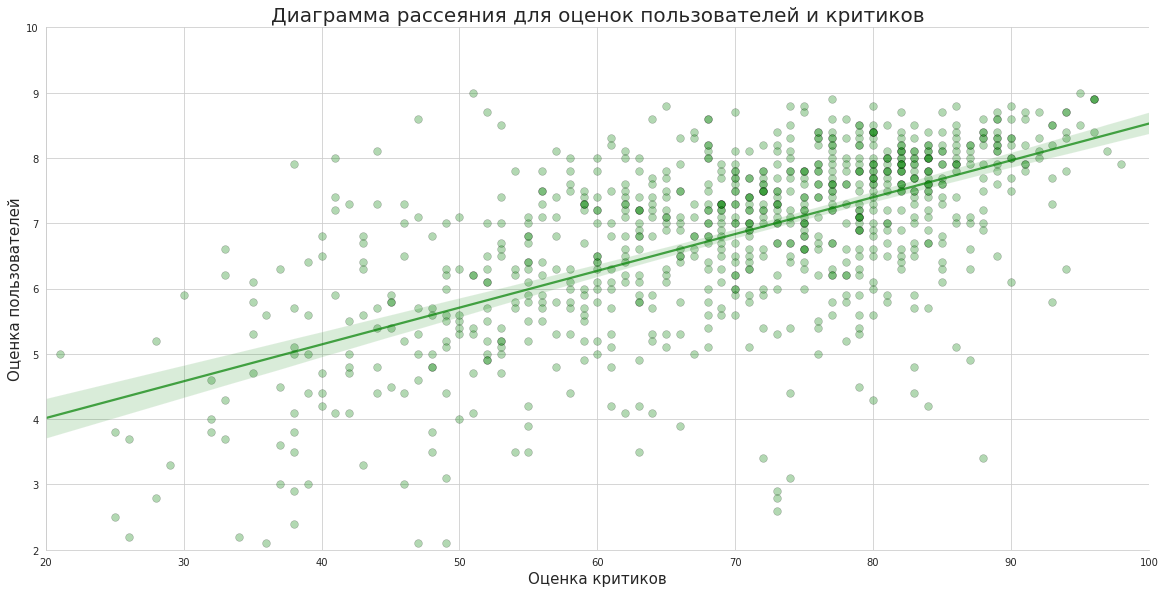

In [127]:
sns.set_style("whitegrid")
ax = sns.lmplot('critic_score','user_score',data=X360_relevant, 
                height=8, aspect=2,
                scatter_kws=dict(s=60, linewidths=.5, color='g', 
                                 edgecolors='black', alpha=0.3),
                line_kws=dict(color='g', alpha=0.7))


ax.set(xlim=(20, 100), ylim=(2, 10))
plt.title("Диаграмма рассеяния для оценок пользователей и критиков", fontsize=20)
plt.ylabel('Оценка пользователей', fontsize=15)
plt.xlabel('Оценка критиков', fontsize=15)
plt.show()

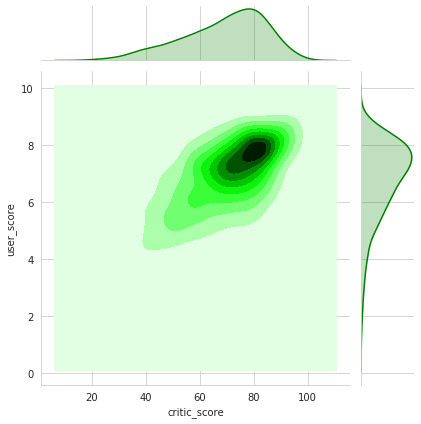

In [128]:
sns.set_style("whitegrid")
sns.jointplot('critic_score','user_score',data=X360_relevant,
              kind="kde", color="g")
plt.show()

Есть прямая зависимость - в среднем оценка критиков и оценка пользователей связаны прямо пропорционально.

И для полноты картины покажем, как связаны оценки критиков и пользователей с суммарными продажами:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

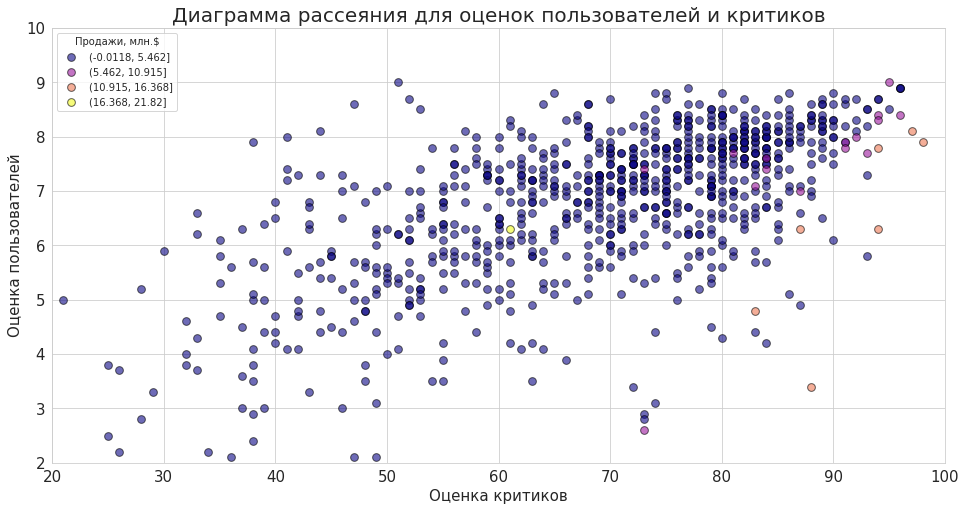

In [129]:
X360_relevant['category'] = pd.cut(X360_relevant['total_sales'], 4)
categories = np.unique(X360_relevant['category'])

colors = [plt.cm.plasma(i/float(len(categories)-1)) 
          for i in range(len(categories))]
plt.figure(figsize=(16, 8), facecolor='w', edgecolor='k')

for i, category in enumerate(categories):
    plt.scatter('critic_score','user_score',
                data=X360_relevant.loc[X360_relevant.category==category, :], 
                s=60, c=colors[i], label=str(category), edgecolor='black', alpha=0.6)

plt.gca().set(xlim=(20, 100), ylim=(2, 10))
plt.title("Диаграмма рассеяния для оценок пользователей и критиков", fontsize=20)
plt.ylabel('Оценка пользователей', fontsize=15)
plt.xlabel('Оценка критиков', fontsize=15)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(title='Продажи, млн.$')    
plt.show()  

Разделив продажи на четыре группы, и выделив игры из соответствующей группы отдельным цветом, можно наблюдать интересное:
-  наиболее продаваемая игра оценена не очень высоко и критиками, и пользователями (оценки чуть более 60 и 6 соответственно)
- игры с продажами в диапазоне 11-16 млн. имеют высокие оценки критиков (выше 80), но при этом среди них есть игры с низким рейтингом от пользователей
- игры с продажами в диапазоне 5.5-11 млн. имеют хорошие оценки критиков (выше 70), и в большинстве случаев хорошие оценки пользователей (выше 7), хотя есть игра с пользовательской оценкой в районе 2.5, что не мешает ей хорошо продаваться
- большая часть игр имеет продажи в пределах 5 млн и оценки в очень широком диапазоне

Еще раз посмотрим, как связаны между собой оценки пользователей, оценки критиков и продажи:

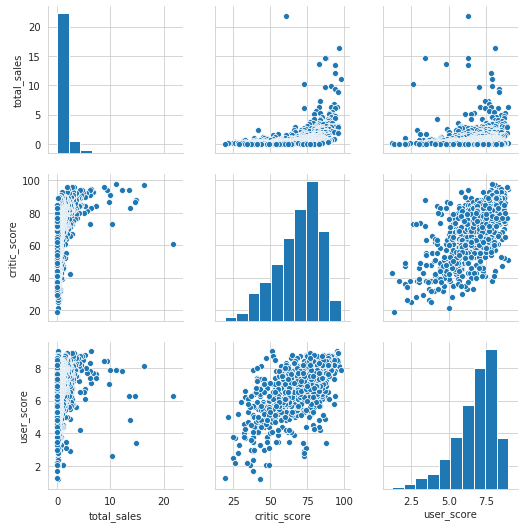

In [130]:
columns = [ 'total_sales', 'critic_score', 'user_score']
sns_plot = sns.pairplot(X360_relevant[columns])

Посчитаем корреляцию между отзывами и продажами игр для X360:

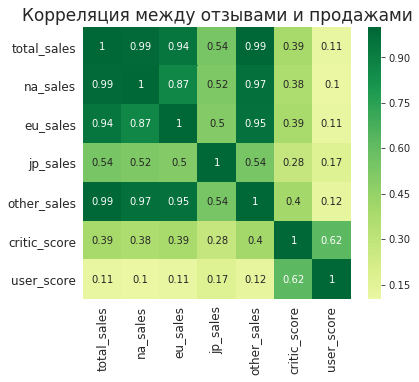

In [131]:
columns = ['total_sales', 'na_sales', 'eu_sales', 'jp_sales', 
           'other_sales', 'critic_score', 'user_score']
plt.figure(figsize=(6,5))
sns.heatmap(X360_relevant[columns].corr(), xticklabels=X360_relevant[columns].corr().columns, 
            yticklabels=X360_relevant[columns].corr().columns, 
            cmap='RdYlGn', center=0, annot=True)

plt.title('Корреляция между отзывами и продажами', fontsize=17)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

В среднем продажи коррелируют больше с оценкой критиков (в случае, когда оценка критиков выше 50), нежели с оценкой пользователей (что весьма странно, так как в итоге именно пользователь покупает или не покупает ту или иную игру). 
Интересно, что оценка критиков и продажи в Японии коррелируют меньше, в то время как именно там выше, чем в среднем, корреляция продаж с оценкой пользователей. 
Обращает на себя внимание высокий коэффициент корреляции оценок пользователей и критиков.

<font color='blue'> Отлично, корреляция проанализирована правильно. </font>

####  <a name="3.7"> Соотнесем выводы с продажами игр на других платформах.</a>

Корреляция между отзывами и продажами для популярных платформ:

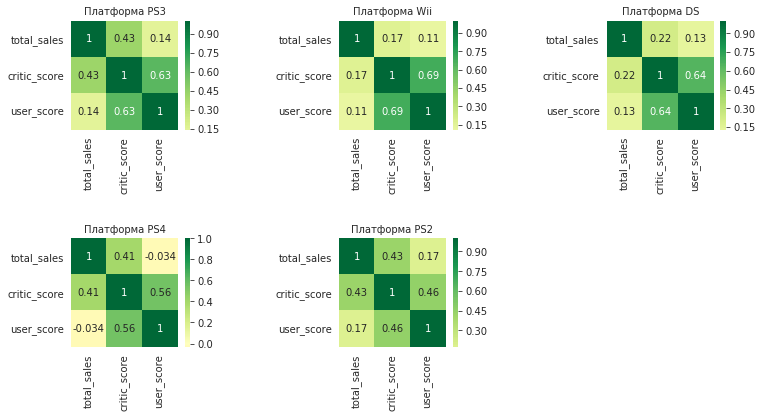

In [132]:
platforms_relevant = games_relevant[(~games_relevant['critic_score'].isna())&
                                    (~games_relevant['user_score'].
                                    isna())].reset_index(drop=True).copy()
platforms_relevant.loc[:,
                       'user_score'] = platforms_relevant.loc[:,
                                                              'user_score'].astype('float64')
top_6_relevant = relevant_platforms['platform'].head(6)

columns = ['total_sales', 
           #'na_sales', 'eu_sales', 'jp_sales', 'other_sales', 
           'critic_score', 'user_score']
fig = plt.figure(figsize=(12,10))
ax1 = fig.add_subplot(3, 3, 1)
ax2 = fig.add_subplot(3, 3, 2)
ax3 = fig.add_subplot(3, 3, 3)
ax4 = fig.add_subplot(3, 3, 4)
ax5 = fig.add_subplot(3, 3, 5)

ax1 = sns.heatmap(platforms_relevant[platforms_relevant['platform'] == 
                                       top_6_relevant[1]][columns].corr(), 
                    xticklabels= platforms_relevant[platforms_relevant['platform'] == 
                                                   top_6_relevant[1]][columns].corr().columns, 
                    yticklabels=platforms_relevant[platforms_relevant['platform'] == 
                                                   top_6_relevant[1]][columns].corr().columns, 
                    ax = ax1, cmap='RdYlGn', center=0, annot=True)
ax1.set_title('Платформа ' + top_6_relevant[1], fontsize=10)

ax2 = sns.heatmap(platforms_relevant[platforms_relevant['platform'] == 
                                       top_6_relevant[2]][columns].corr(), 
                    xticklabels=platforms_relevant[platforms_relevant['platform'] == 
                                                   top_6_relevant[2]][columns].corr().columns, 
                    yticklabels=platforms_relevant[platforms_relevant['platform'] == 
                                                   top_6_relevant[2]][columns].corr().columns, 
                    ax = ax2, cmap='RdYlGn', center=0, annot=True)
ax2.set_title('Платформа ' + top_6_relevant[2], fontsize=10)

ax3 = sns.heatmap(platforms_relevant[platforms_relevant['platform'] == 
                                       top_6_relevant[3]][columns].corr(), 
                    xticklabels=platforms_relevant[platforms_relevant['platform'] == 
                                                   top_6_relevant[3]][columns].corr().columns, 
                    yticklabels=platforms_relevant[platforms_relevant['platform'] == 
                                                   top_6_relevant[3]][columns].corr().columns, 
                    ax = ax3, cmap='RdYlGn', center=0, annot=True)
ax3.set_title('Платформа ' + top_6_relevant[3], fontsize=10)

ax4 = sns.heatmap(platforms_relevant[platforms_relevant['platform'] == 
                                       top_6_relevant[4]][columns].corr(), 
                    xticklabels=platforms_relevant[platforms_relevant['platform'] == 
                                                   top_6_relevant[4]][columns].corr().columns, 
                    yticklabels=platforms_relevant[platforms_relevant['platform'] == 
                                                   top_6_relevant[4]][columns].corr().columns, 
                    ax = ax4, cmap='RdYlGn', center=0, annot=True)
ax4.set_title('Платформа ' + top_6_relevant[4], fontsize=10)


ax5 = sns.heatmap(platforms_relevant[platforms_relevant['platform'] == 
                                       top_6_relevant[5]][columns].corr(), 
                    xticklabels=platforms_relevant[platforms_relevant['platform'] == 
                                                   top_6_relevant[5]][columns].corr().columns, 
                    yticklabels=platforms_relevant[platforms_relevant['platform'] == 
                                                   top_6_relevant[5]][columns].corr().columns, 
                    ax = ax5, cmap='RdYlGn', center=0, annot=True)
ax5.set_title('Платформа ' + top_6_relevant[5], fontsize=10)

plt.subplots_adjust(wspace = 1, hspace = 1)
plt.show()

- Наибольшая корреляция оценки критиков и продаж - у платформы Wii. Сравнимая связь у этих величин - для платформ  PS3 и DS. 
- Наименьшим образом коррелируют оценки пользователей и продажи у игр для той же платформы Wii. 
- Наибольшим образом коррелируют оценки пользователей и продажи у игр для платформ семейства Play Station.
- Интересно, что успешность продаж игр для новой консоли PS4 совсем не коррелирует с оценкой пользователя.

<a name="ссыль">Посмотрим </a>, как критики оценивают игры для той или иной популярной платформы:

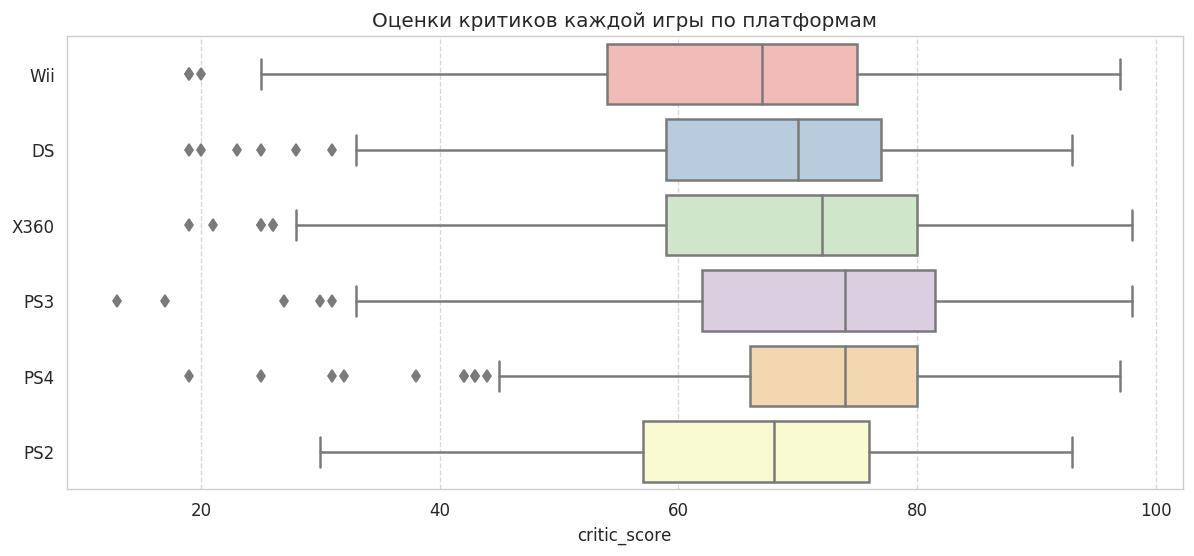

In [192]:
plt.figure(figsize=(12, 5), dpi=120)
plt.title('Оценки критиков каждой игры по платформам')
plt.grid(linestyle='--', which='major',
         color='grey', alpha=.3)
sns.boxplot(y="platform", x="critic_score", 
            data=platforms_relevant[platforms_relevant.platform.isin(top_6_relevant)], 
            orient="h",
           palette = 'Pastel1')
plt.ylabel('')
plt.show()

- Чаще всего критики благосклонны к играм семейства Play Station, а именно - для платформ PS3 и PS4.
- Игры, выходящие для "поживших" платформ, таких как Wii, DS, PS2, в основной массе имеют рейтинг ниже, чем у игр для более современных платформ. 
- Для последней из вышедших платформ - PS4 - по оценке критиков, выпускается больше удачных игр, хотя, вероятно, ввиду молодости этой платформы,  все еще не так много игр с очень высокими оценками, чем для  PS3, к примеру.
- Среди игр для DS меньше оцененных критиками шедевров, возможно, ввиду того, что это портативная консоль, что накладывает свои ограничения на качества, оцениваемые критиками.

Посмотрим , как пользователи оценивают игры для той или иной популярной платформы:

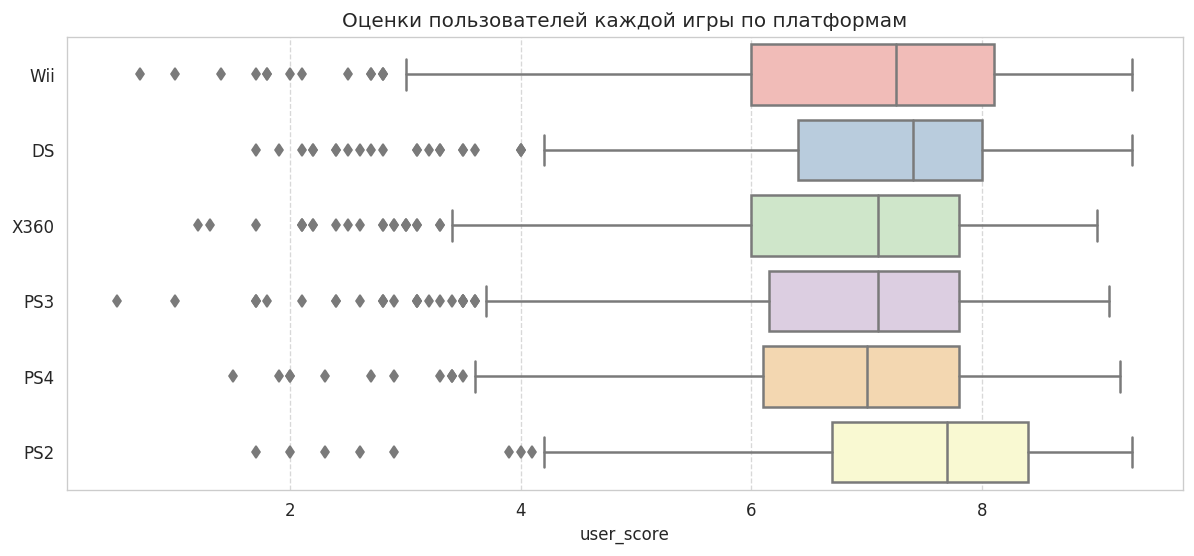

In [191]:
plt.figure(figsize=(12, 5), dpi=120)
plt.title('Оценки пользователей каждой игры по платформам')
plt.grid(linestyle='--', which='major',
         color='grey', alpha=.3)
sns.boxplot(y="platform", x="user_score", 
            data=platforms_relevant[platforms_relevant.platform.isin(top_6_relevant)], 
            orient="h",
           palette = 'Pastel1')
plt.ylabel('')
plt.show()

Интересно, что в случае оценок пользователей ситуация иная:
-  Пользователи выше оценивают игры для PS2
-  Также обращает на себя внимание тот факт, что игры для портативной DS пользователи ценят относительно выше, чем критики
-  Также игры для Wii, относительно невысоко оцененные критиками, в среднем больше нравятся пользователям, чем игры для популярных X360, PS3 и PS4

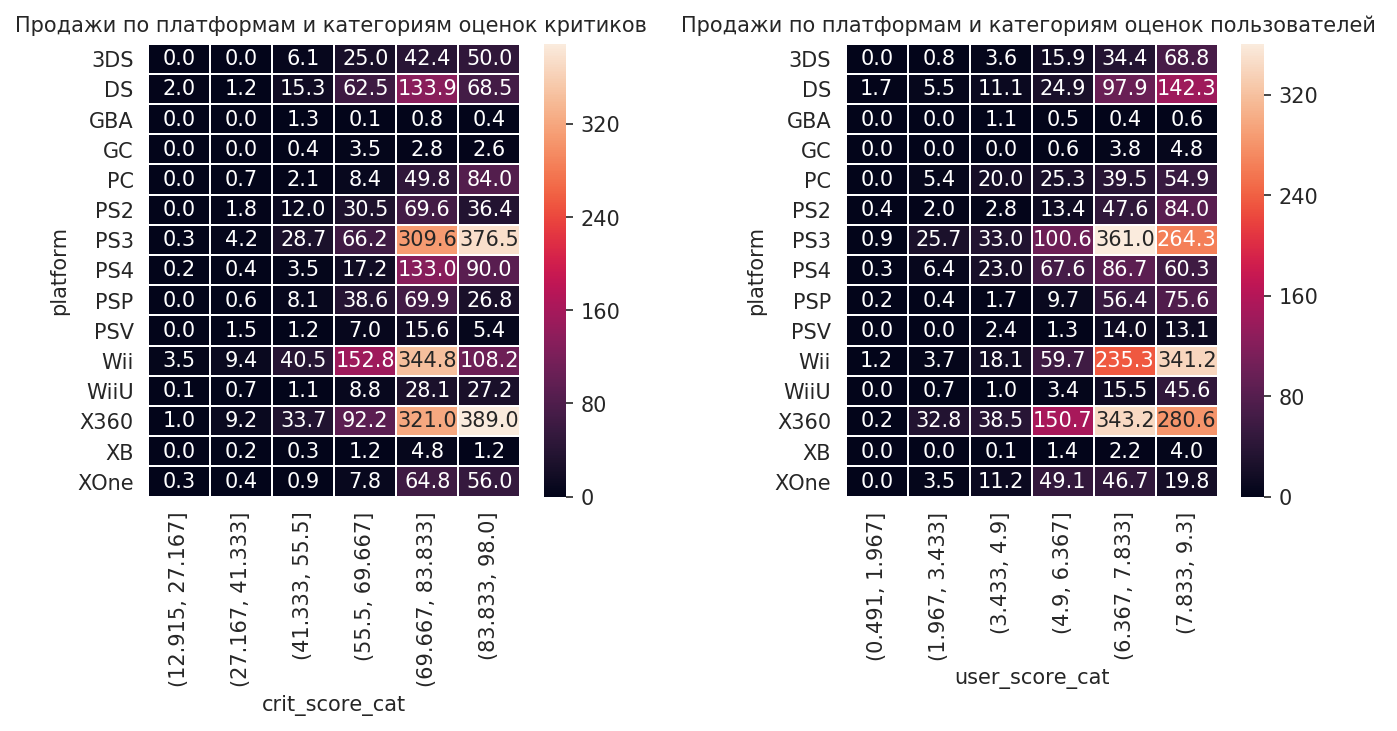

In [134]:
platforms_relevant['crit_score_cat'] = pd.cut(platforms_relevant['critic_score'], 6)
platforms_relevant['user_score_cat'] = pd.cut(platforms_relevant['user_score'], 6)

pltfrm_crit_scr_sales = platforms_relevant.pivot_table(index='platform', 
                                                       columns='crit_score_cat', 
                                                       values='total_sales', 
                                                       aggfunc=sum).fillna(0).applymap(float)
pltfrm_user_scr_sales = platforms_relevant.pivot_table(
                        index='platform', 
                        columns='user_score_cat', 
                        values='total_sales', 
                        aggfunc=sum).fillna(0).applymap(float)

fig = plt.figure(figsize=(16,10), dpi = 150)
ax1 = fig.add_subplot(2, 3, 1)
ax2 = fig.add_subplot(2, 3, 2)

sns.heatmap(pltfrm_crit_scr_sales, ax = ax1, annot=True, fmt=".1f", linewidths=.5)
sns.heatmap(pltfrm_user_scr_sales, ax = ax2, annot=True, fmt=".1f", linewidths=.5)
ax2.set_title('Продажи по платформам и категориям оценок пользователей ', fontsize=10)
ax1.set_title('Продажи по платформам и категориям оценок критиков ', fontsize=10)

plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
plt.show()

Резюмируя - планируя рекламную кампанию, стоит больше обращать внимания на оценку критиков, так как она коррелирует в итоге с продажами.

<font color='blue'> Очень тщательный подход к кореляции, молодец. </font>

####  <a name="3.8"> Посмотрим на общее распределение игр по жанрам.</a>  
Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

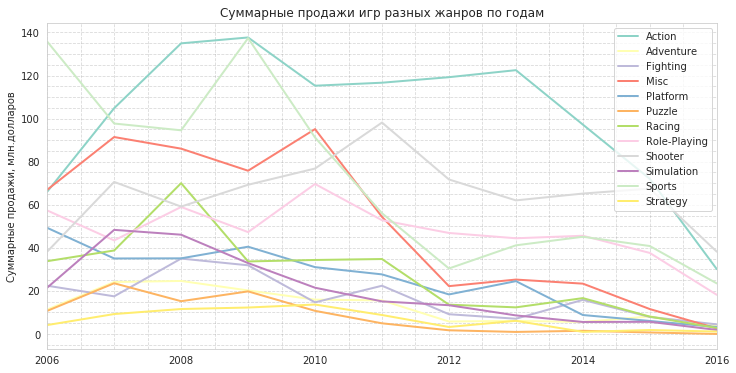

In [135]:
genre_dynamics = games_relevant.pivot_table(values = 'total_sales', 
                                            index = 'year_of_release',
                                            columns = 'genre', 
                                            aggfunc = 'sum')

genre_dynamics.plot(figsize=(12, 6), lw=2, alpha=1, cmap="Set3")
plt.minorticks_on()
plt.grid(linestyle='--', which='major',
         color='grey', alpha=.3)
plt.grid(which='minor', 
        color = 'grey', 
        linestyle = '--', alpha=.3)
plt.title('Суммарные продажи игр разных жанров по годам')
plt.ylabel('Суммарные продажи, млн.долларов')
plt.xlabel('')
plt.xlim(2006, 2016)
plt.legend()
plt.show()

In [136]:
games_relevant.groupby(['genre']).sum()['total_sales'].sort_values(ascending=False)

genre
Action          1116.65
Sports           793.85
Shooter          717.04
Misc             554.86
Role-Playing     522.40
Racing           299.00
Platform         279.74
Simulation       220.65
Fighting         188.42
Adventure        141.35
Puzzle            89.92
Strategy          73.14
Name: total_sales, dtype: float64

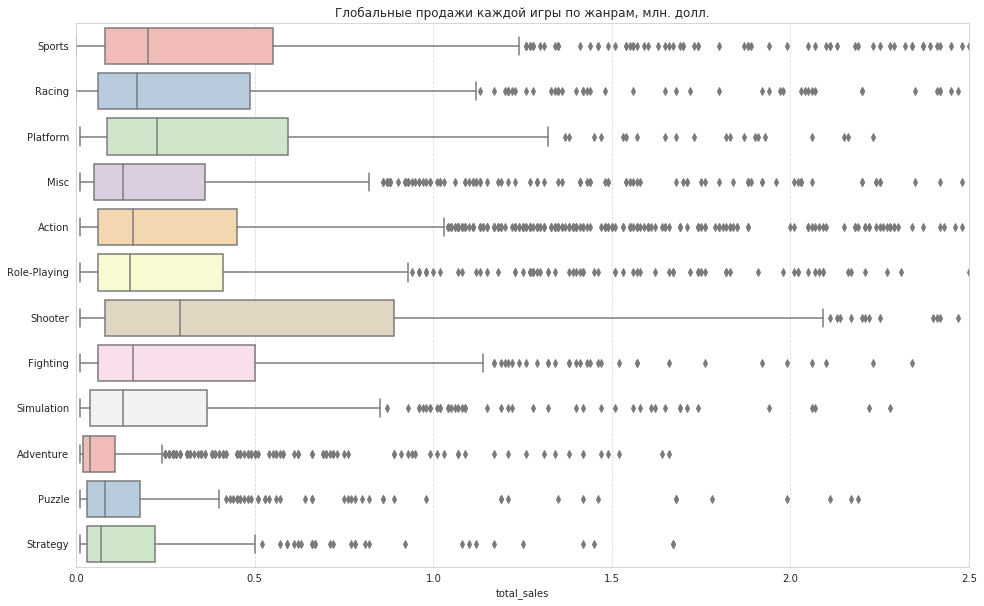

In [137]:
plt.figure(figsize=(16, 10))
plt.xlim(0,2.5)
plt.title('Глобальные продажи каждой игры по жанрам, млн. долл.')

plt.grid(linestyle='--', which='major',
         color='grey', alpha=.3)
sns.boxplot(y="genre", x="total_sales", 
            data=games_relevant, 
            orient="h",
            palette = 'Pastel1')
plt.ylabel('')
plt.show()

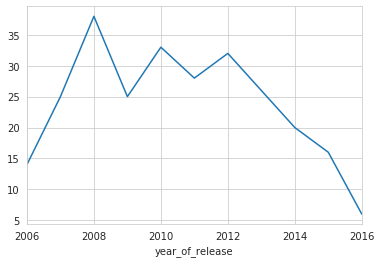

In [138]:
games_relevant[(games_relevant['genre'] == 'Action')&
               (games_relevant['total_sales'] > 1)].groupby('year_of_release')['total_sales'].count().plot()

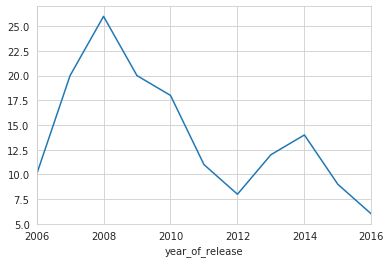

In [139]:
games_relevant[(games_relevant['genre'] == 'Sports')&
               (games_relevant['total_sales'] > 1)].groupby('year_of_release')['total_sales'].count().plot()

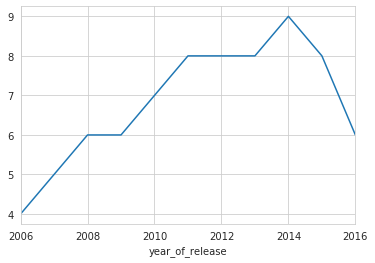

In [140]:
games_relevant[(games_relevant['genre'] == 'Shooter')&
               (games_relevant['total_sales'] > 2.2)].groupby('year_of_release')['total_sales'].count().plot()

- Самые прибыльные жанры за последнюю декаду - это Action, Sports и Shooter. Но рассмотрим три эти жанра подробнее, и увидим, что игры жанра Action делают большие продажи не за счет хороших продаж основной массы игр этого жанра, а за счет бестселлеров этого жанра, удачных Action-игр, которые собирают кассу. На plot-графике можно наблюдать, что такие хиты появляются не каждый год. Кроме того, в последние годы идет тренд как на снижение общих продаж в этом жанре, так и на уменьшение количества бестселлеров. Жанр сдает позиции!
- Продажи игр в жанре Sports также показывают отрицательную динамику. Даже не смотря на то, что за последние 2-3 года статистики мы не видим финальных, полных продаж игры, которые можем сравнить с продажами игр, вышедших ранее, все же начиная с 2008 года видим постепенное снижение продаж игр жанра Sports.
- А вот игры жанра Shooter - более надежны в плане продаж, в большинстве случаев продажи игр этого жанра выше, чем продажи предыдущих двух жанров. Общие продажи не так велики, так как бестселлеров в этом жанре выходит меньше, однако же, планируя продажи на следующий год, не правильно полагаться на удачу, и ждать новых хитов в жанре Action, надежнее рассчитывать на более высокие в большинстве случаев продажи игр жанра Shooter. Что, тем не менее, не мешает продавать известные бестселлеры жанров Action и Sports, по которым можно ожидать высокий спрос и продажи.
- Наименее прибыльные с точки зрения продаж жанры, это Adventure, Puzzle и Strategy. На игры этого жанра делать ставку точно не стоит!

### <a name="4"> Шаг 4. Портрет пользователя каждого региона </a>
Определим для пользователя каждого региона (NA, EU, JP):
- [Самые популярные платформы (топ-5)](#4.1)
- [Самые популярные жанры (топ-5)](#4.2)
- [Влияет ли рейтинг ESRB на продажи в отдельном регионе?](#4.3)

#### <a name="4.1"> Самые популярные платформы (топ-5) для пользователя каждого региона (NA, EU, JP)</a>

Посмотрим, как в последнее десятилетие распределяются объемы продаж по регионам:

In [141]:
sales_rgn = pd.DataFrame()
sales_rgn.loc[0, 'na_sales'] = games_relevant['na_sales'].sum()
sales_rgn.loc[0, 'eu_sales'] = games_relevant['eu_sales'].sum()
sales_rgn.loc[0, 'jp_sales'] = games_relevant['jp_sales'].sum()
sales_rgn.loc[0, 'other_sales'] = games_relevant['other_sales'].sum()
sales_sum = sales_rgn.loc[0].sum()
sales_rgn_prp = sales_rgn/sales_sum
sales_rgn_prp.applymap("{0:.1%}".format)

,na_sales,eu_sales,jp_sales,other_sales
0,47.8%,29.9%,11.2%,11.1%


Почти половина всех мировых продаж в последние 10 лет делается в Северной Америке, около 30% продаж приходится на Европу, 11% - это рынок Японии (довольно большой, относительно размеров региона), и те же 11% - все остальные страны. Популярность видеоигр в Японии можно объяснить тем, что именно Япония - родина индустрии видеоигр, там производятся и сейчас платформы - лидеры рынка.

In [142]:
region_sales = games_relevant.groupby(['platform']).sum().loc[:,'na_sales': 'other_sales']

Посмотрим, какие платформы лидируют в каждом из регионов (за последние 10 лет):

In [143]:
top_5 = pd.DataFrame()
top_5['North America'] = region_sales['na_sales'].sort_values(ascending=
                                                              False).head(5).index.values
top_5['Europe'] = region_sales['eu_sales'].sort_values(ascending=False).head(5).index.values
top_5['Japan'] = region_sales['jp_sales'].sort_values(ascending=False).head(5).index.values
top_5['Other countries'] = region_sales['other_sales'].sort_values(ascending=
                                                                   False).head(5).index.values
top_platforms = np.unique(top_5.values) 
top_5

,North America,Europe,Japan,Other countries
0,X360,PS3,DS,PS3
1,Wii,X360,3DS,X360
2,PS3,Wii,PS3,Wii
3,DS,DS,PSP,PS2
4,PS2,PS4,Wii,PS4


Рассчитаем доли продаж по каждому из регионов для самых популярных платформ:

In [144]:
na_total = region_sales['na_sales'].sum()
eu_total = region_sales['eu_sales'].sum()
jp_total = region_sales['jp_sales'].sum()
other_total = region_sales['other_sales'].sum()
rgn_sales_prop = pd.DataFrame()
rgn_sales_prop['na_sales'] = region_sales['na_sales']/na_total
rgn_sales_prop['eu_sales'] = region_sales['eu_sales']/eu_total
rgn_sales_prop['jp_sales'] = region_sales['jp_sales']/jp_total
rgn_sales_prop['other_sales'] = region_sales['other_sales']/other_total
rgn_sales_prop[rgn_sales_prop.index.
               isin(top_platforms)].sort_values(by='na_sales', 
                                                ascending=False).applymap("{0:.1%}".format)


,na_sales,eu_sales,jp_sales,other_sales
platform,,,,
X360,24.7%,17.9%,2.1%,15.2%
Wii,20.4%,17.3%,12.2%,14.1%
PS3,16.3%,21.9%,14.1%,24.3%
DS,13.6%,9.6%,25.2%,8.5%
PS2,4.8%,3.1%,6.4%,12.4%
PS4,4.6%,9.4%,2.8%,8.7%
3DS,3.5%,4.1%,17.9%,2.4%
PSP,3.4%,3.6%,12.6%,6.0%


Также можно рассмотреть в другом разрезе - как продажи внутри одной платформы распределились между регионами:

In [145]:
region_sales['total_sales'] = (region_sales['na_sales'] + region_sales['eu_sales'] 
                               + region_sales['jp_sales'] + region_sales['other_sales'])
region_sales['na_sales_prp'] = region_sales['na_sales'] / region_sales['total_sales']
region_sales['eu_sales_prp'] = region_sales['eu_sales'] / region_sales['total_sales']
region_sales['jp_sales_prp'] = region_sales['jp_sales'] / region_sales['total_sales']
region_sales['other_sales_prp'] = region_sales['other_sales'] / region_sales['total_sales']
region_sales[region_sales.
             index.
             isin(top_platforms)].loc[:, 'na_sales_prp':
                                      'other_sales_prp'].sort_values(by='na_sales_prp', 
                                                                     ascending=
                                                                     False).applymap("{0:.1%}".
                                                                                     format)

,na_sales_prp,eu_sales_prp,jp_sales_prp,other_sales_prp
platform,,,,
X360,61.8%,28.1%,1.3%,8.8%
Wii,54.6%,29.0%,7.7%,8.7%
DS,49.4%,21.8%,21.6%,7.2%
PS2,43.2%,17.4%,13.5%,25.8%
PS3,41.9%,35.1%,8.5%,14.5%
PS4,34.6%,44.9%,5.1%,15.4%
PSP,33.8%,22.7%,29.6%,13.9%
3DS,32.1%,23.8%,39.0%,5.1%


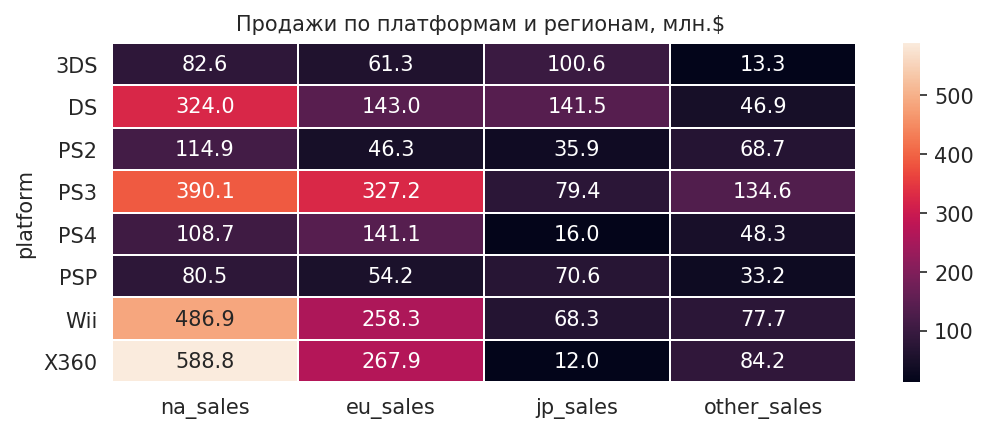

In [163]:
plt.figure(figsize=(8,3), dpi = 150)
plt.title('Продажи по платформам и регионам, млн.$ ', fontsize=10)
sns.heatmap(region_sales[region_sales.index.isin(top_platforms)].loc[:, 'na_sales':
                                      'other_sales'], 
            annot=True, fmt=".1f", linewidths=.5)
plt.show()

- В Европе, Северной Америке и других странах тройка лидеров одна, только по-разному распределились места в каждом из регионов. На первом месте в каждом из регионов разные платформы с долей продаж 20-25%.
- В америке ожидаемо лидирует платформа X360 производства американской компании Microsoft.
- Япония выделяется любовью к платформам производства японской компании Nintendo - DS, DS3, Wii, а также к платформам производства американской дочки японской компании Sony -  PS3 и PSP.  При этом платформа X360 американской компании Microsoft вообще отсутствует в японском топе. 
- Выяснили, что
   -  игры для платформ X360, Wii, DS, PS2, PS3 и PSP лучше всего продаются в Северной Америке,
   -  продажи для платформы PS4 выше всего в Европе
   -  3DS лидирует по продажам в Японии, обращает на себя внимание также популярность в Японии консоли PSP
   -  в других странах можно выделить популярность консолей семейства Play Station


#### <a name="4.2"> Самые популярные жанры (топ-5) для пользователя каждого региона (NA, EU, JP)</a> 

In [168]:
region_genres = games_relevant.groupby(['genre']).sum().loc[:,'na_sales': 'other_sales']

Посмотрим, какие жанры лидируют в каждом из регионов (за последние 10 лет):

In [169]:
top_5_genres = pd.DataFrame()
top_5_genres['North America'] = region_genres['na_sales'].sort_values(ascending=
                                                                      False).head(5).index.values
top_5_genres['Europe'] = region_genres['eu_sales'].sort_values(ascending=
                                                               False).head(5).index.values
top_5_genres['Japan'] = region_genres['jp_sales'].sort_values(ascending=
                                                              False).head(5).index.values
top_5_genres['Other countries'] = region_genres['other_sales'].sort_values(ascending=
                                                                   False).head(5).index.values
top_genres = np.unique(top_5_genres.values) 
top_5_genres

,North America,Europe,Japan,Other countries
0,Action,Action,Role-Playing,Action
1,Sports,Sports,Action,Sports
2,Shooter,Shooter,Misc,Shooter
3,Misc,Misc,Sports,Misc
4,Role-Playing,Racing,Platform,Role-Playing


Рассчитаем доли продаж по каждому из регионов для самых популярных жанров:

In [170]:
na_total = region_genres['na_sales'].sum()
eu_total = region_genres['eu_sales'].sum()
jp_total = region_genres['jp_sales'].sum()
other_total = region_genres['other_sales'].sum()
rgn_genres_prop = pd.DataFrame()
rgn_genres_prop['na_sales'] = region_genres['na_sales']/na_total
rgn_genres_prop['eu_sales'] = region_genres['eu_sales']/eu_total
rgn_genres_prop['jp_sales'] = region_genres['jp_sales']/jp_total
rgn_genres_prop['other_sales'] = region_genres['other_sales']/other_total
rgn_genres_prop[rgn_genres_prop.
                index.
                isin(top_genres)].sort_values(by='na_sales', 
                                              ascending=False).applymap("{0:.1%}".format)


,na_sales,eu_sales,jp_sales,other_sales
genre,,,,
Action,22.2%,23.4%,18.2%,24.1%
Sports,16.6%,16.8%,8.7%,17.5%
Shooter,15.6%,16.0%,3.4%,15.5%
Misc,11.9%,9.8%,11.5%,10.6%
Role-Playing,8.4%,7.4%,30.4%,7.6%
Platform,5.6%,5.5%,6.3%,5.2%
Racing,5.6%,7.6%,2.4%,7.1%


Также можно рассмотреть в другом разрезе - как продажи внутри одного жанра распределились между регионами:

In [171]:
region_genres['total_sales'] = (region_genres['na_sales'] + region_genres['eu_sales'] 
                               + region_genres['jp_sales'] + region_genres['other_sales'])
region_genres['na_sales_prp'] = region_genres['na_sales'] / region_genres['total_sales']
region_genres['eu_sales_prp'] = region_genres['eu_sales'] / region_genres['total_sales']
region_genres['jp_sales_prp'] = region_genres['jp_sales'] / region_genres['total_sales']
region_genres['other_sales_prp'] = region_genres['other_sales'] / region_genres['total_sales']
region_genres[region_genres.
             index.
             isin(top_genres)].loc[:, 'na_sales_prp':
                                      'other_sales_prp'].sort_values(by='na_sales_prp', 
                                                                     ascending=
                                                                     False).applymap("{0:.1%}".
                                                                                     format)

,na_sales_prp,eu_sales_prp,jp_sales_prp,other_sales_prp
genre,,,,
Shooter,52.0%,33.3%,2.7%,11.9%
Misc,51.4%,26.5%,11.6%,10.5%
Sports,50.0%,31.7%,6.2%,12.2%
Platform,48.0%,29.2%,12.6%,10.2%
Action,47.5%,31.4%,9.1%,12.0%
Racing,44.5%,37.9%,4.4%,13.2%
Role-Playing,38.2%,21.2%,32.6%,8.0%


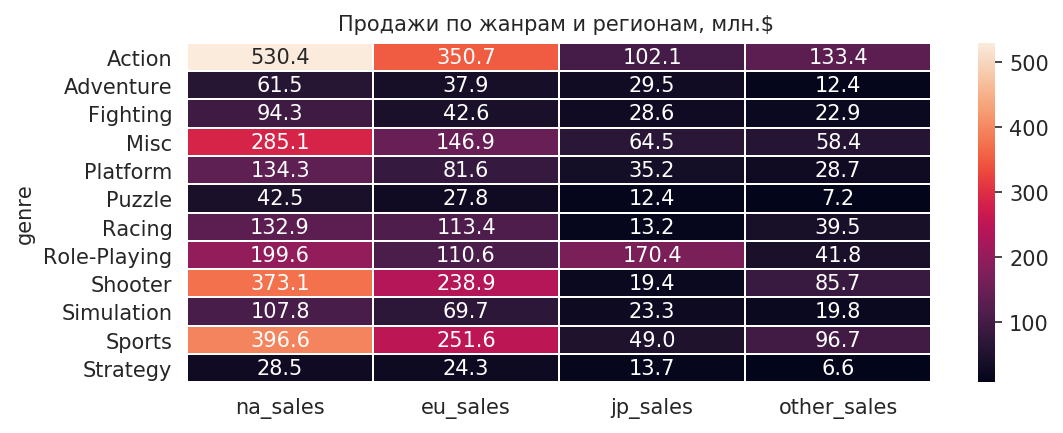

In [172]:
plt.figure(figsize=(8,3), dpi = 150)
plt.title('Продажи по жанрам и регионам, млн.$ ', fontsize=10)
sns.heatmap(region_genres.loc[:, 'na_sales':
                              'other_sales'], annot=True, fmt=".1f", linewidths=.5)
plt.show()

- В Северной Америке, Европе и других странах популярней всего игры жанра Action, Sports и Shooter
- В Японии с отрывом лидируют по продажам игры в жанре Role-Playing, далее в рейтинге игры в жанре Action, на третьем месте - игры в жанре Misc  
-  В Японии игры в жанре Shooter наименее продаваемые из всех популярных жанров

Интересно отличие японского пользователя от пользователей из других стран - страна-родина видеоигр живет по своим правилам, и предпочтения продиктованы принципиально иным культурным кодом.

#### <a name="4.3"> Влияет ли рейтинг ESRB на продажи в отдельном регионе?</a>

In [173]:
region_rating = games_relevant.groupby(['rating']).sum().loc[:,'na_sales': 'other_sales']

Посмотрим, игры с какими рейтингами ESRB лидируют в каждом из регионов (за последние 10 лет):

In [180]:
top_5_rating = pd.DataFrame()
top_5_rating['North America'] = region_rating['na_sales'].sort_values(ascending=False).head(5).index.values
top_5_rating['Europe'] = region_rating['eu_sales'].sort_values(ascending=False).head(5).index.values
top_5_rating['Japan'] = region_rating['jp_sales'].sort_values(ascending=False).head(5).index.values
top_5_rating['Other countries'] = region_rating['other_sales'].sort_values(ascending=
                                                                   False).head(5).index.values
top_rating = np.unique(top_5_rating.values) 
top_5_rating = top_5_rating.replace('E', 'E: Everyone')
top_5_rating = top_5_rating.replace('M', 'M: Mature 17+')
top_5_rating = top_5_rating.replace('T', 'T: Teen 13+')
top_5_rating = top_5_rating.replace('E10+', 'E10+: Everyone 10+')
top_5_rating = top_5_rating.replace('EC', 'EC: Early childhood')
top_5_rating = top_5_rating.replace('RP', 'Rating Pending')

top_5_rating

,North America,Europe,Japan,Other countries
0,E: Everyone,E: Everyone,Unknown,E: Everyone
1,M: Mature 17+,M: Mature 17+,E: Everyone,M: Mature 17+
2,T: Teen 13+,T: Teen 13+,T: Teen 13+,T: Teen 13+
3,E10+: Everyone 10+,Unknown,M: Mature 17+,Unknown
4,Unknown,E10+: Everyone 10+,E10+: Everyone 10+,E10+: Everyone 10+


In [179]:
na_total = region_rating['na_sales'].sum()
eu_total = region_rating['eu_sales'].sum()
jp_total = region_rating['jp_sales'].sum()
other_total = region_rating['other_sales'].sum()
rgn_rating_prop = pd.DataFrame()
rgn_rating_prop['na_sales'] = region_rating['na_sales']/na_total
rgn_rating_prop['eu_sales'] = region_rating['eu_sales']/eu_total
rgn_rating_prop['jp_sales'] = region_rating['jp_sales']/jp_total
rgn_rating_prop['other_sales'] = region_rating['other_sales']/other_total
rgn_rating_prop[rgn_rating_prop.
                index.
                isin(top_rating)].sort_values(by='na_sales', 
                                              ascending=False).applymap("{0:.1%}".format)

,na_sales,eu_sales,jp_sales,other_sales
rating,,,,
E,33.4%,30.8%,21.4%,29.4%
M,24.1%,26.7%,7.8%,25.4%
T,17.8%,15.7%,14.9%,19.1%
E10+,13.2%,11.6%,6.5%,12.2%
Unknown,11.5%,15.2%,49.3%,13.8%


Также можно рассмотреть в другом разрезе - как продажи игр каждой возрастной группы распределились между регионами:

In [157]:
region_rating['total_sales'] = (region_rating['na_sales'] + region_rating['eu_sales'] 
                               + region_rating['jp_sales'] + region_rating['other_sales'])
region_rating['na_sales_prp'] = region_rating['na_sales'] / region_rating['total_sales']
region_rating['eu_sales_prp'] = region_rating['eu_sales'] / region_rating['total_sales']
region_rating['jp_sales_prp'] = region_rating['jp_sales'] / region_rating['total_sales']
region_rating['other_sales_prp'] = region_rating['other_sales'] / region_rating['total_sales']
region_rating[region_rating.
             index.
             isin(top_rating)].loc[:, 'na_sales_prp':
                                      'other_sales_prp'].sort_values(by='na_sales_prp', 
                                                                     ascending=
                                                                     False).applymap("{0:.1%}".
                                                                                     format)

,na_sales_prp,eu_sales_prp,jp_sales_prp,other_sales_prp
rating,,,,
E10+,53.2%,29.2%,6.2%,11.4%
E,51.7%,29.9%,7.8%,10.5%
T,49.9%,27.7%,9.9%,12.5%
M,49.6%,34.5%,3.8%,12.2%
Unknown,32.1%,26.6%,32.4%,8.9%


Распределение продаж игр каждой возрастной категории примерно соответствует распределению общих продаж, но обращает на себя внимание Япония, где менее распространена рейтинговая система ESRB (это северно-американская ассоциация, возможно, причина в этом).

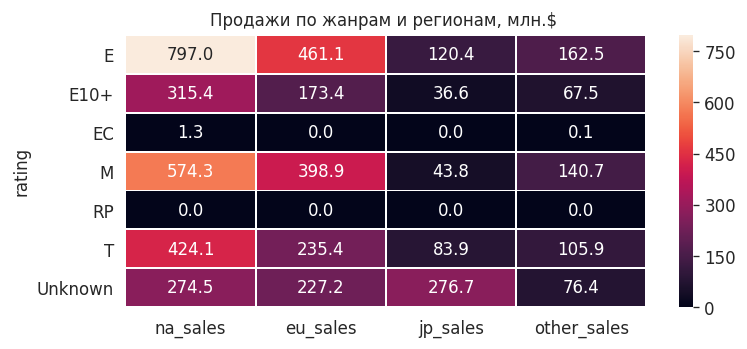

In [175]:
plt.figure(figsize=(7,3), dpi = 120)
plt.title('Продажи по жанрам и регионам, млн.$ ', fontsize=10)
sns.heatmap(region_rating.loc[:, 'na_sales':
                              'other_sales'], annot=True, fmt=".1f", linewidths=.5)
plt.show()

- Во всем мире, кроме Японии, в последнее десятилетие лидируют по продажам игры с рейтингом "E" - игры для всех возрастов
     -  больше половины всех игр с рейтингом "E" продается в Северной Америке
     -  в целом продажи игр с рейтингом "E" распределились по регионам соответственно распределению общих продаж в этих регионах, что говорит о том, что такие игры одинаково популярны во всем мире
- В Японии больше всего продается игр вообще без рейтинга ESRB. Вторые по продажам - игры с рейтингом "E"(для всех)
- Игры с рейтингом "M", для лиц старше 17 лет, вторые по популярности во всем мире, исключая Японию - там они уступили играм для подростков (рейтинг "T")
- В свою очередь, игры с рейтингом "T" третьи по популярности в мире
- Игры для всех, кто старше 10 лет (рейтинг "E10+") - четвертые в Северной Америке по популярности, во всем остальном мире же они на пятом месте по продажам
- В Европе и других странах на четвертом месте по продажам - игры без рейтинга ESRB


Можно предполагать, что:
- **типичный пользователь из Северной Америки**
    - предпочитает X360, Wii или PS3
    - чаще выбирает игры жанра Action, Sports и Shooter
    - не меньше чем в 24% случаев - старше 17 лет 
- **типичный пользователь из Европы**
    - отдает предпочтение PS3, но также выбирает X360 и Wii
    - также чаще выбирает игры жанра Action, Sports и Shooter
    - не меньше чем в 26% случаев - старше 17 лет 
- **типичный пользователь из Японии**    
    - отдает предпочтение играм для платформ производства японских компаний Nintendo и Sony
    - чаще, чем жители других регионов, выбирает портативные игровые консоли, такие как PSP  и DS3
    - обладает нетипичным для американцев и европейцев вкусом: чаще выбирает игры жанра Role-Playing, Action и Misc
    - ввиду не очень большой популярности рейтинга ESRB (почти половина всех продаваемых в Японии игр не рейтингована по ESRB) объективной статистики по возрастам пользователей составить нельзя, по имеющимся же данным взрослых среди пользователей - не менее 7%, подростков - около 15% (хотя в игры для подростков могут играть и взрослые)
- **типичный пользователь из других стран**
    - любит PS3 даже больше, чем житель Европы, и, как и он, выбирает также X360 и Wii
    - солидарен в своих предпочтениях с жителями Европы и Северной Америки: чаще выбирает игры жанра Action, Sports и Shooter
    - в не менее чем в 25% случаев - взрослый, не менее чем в 19% случаев - подросток

### <a name="5">  Шаг 5. Проверка гипотез </a>
- [Гипотеза №1: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые](#5.1)
- [Гипотеза №2: Средние пользовательские рейтинги жанров Action и Sports разные](#5.2)

#### <a name="5.1">  Гипотеза #1: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые </a>

Найдем средний пользовательский рейтинг для платформ Xbox One и PC:

In [71]:
mean_user_scr_xone = games[games['platform'] == 'XOne']['user_score'].mean()
mean_user_scr_pc = games[games['platform'] == 'PC']['user_score'].mean()
print('Cредний пользовательский рейтинг для Xbox One: ', mean_user_scr_xone)
print('Cредний пользовательский рейтинг для PC: ', mean_user_scr_pc)

Cредний пользовательский рейтинг для Xbox One:  6.52142857142857
Cредний пользовательский рейтинг для PC:  7.062467532467546


Проверим гипотезу о равенстве средних пользовательских рейтингов для платформ Xbox One и PC (примем ее за нулевую гипотезу). 

Альтернативная гипотеза: средние пользовательские рейтинги для платформ Xbox One и PC не равны. 

Чтобы проверить гипотезу о равенстве среднего двух генеральных совокупностей по взятым из них выборкам, применим метод `scipy.stats.ttest_ind`.
Пороговое значение alpha примем за 0.5.

In [72]:
user_scr_xone = games[(games['platform'] == 'XOne')&
                              (~games['user_score'].isna())]['user_score']
user_scr_pc = games[(games['platform'] == 'PC')&
                            (~games['user_score'].isna())]['user_score']
alpha = .05
results = stats.ttest_ind(
    user_scr_xone,
    user_scr_pc)
print('p-значение:', results.pvalue)
if (results.pvalue < alpha):   
    print("Отвергаем нулевую гипотезу:")
    print("средние пользовательские рейтинги для платформ XOne и PC отличаются статистически значимо")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.3896435533540507e-05
Отвергаем нулевую гипотезу:
средние пользовательские рейтинги для платформ XOne и PC отличаются статистически значимо


Выяснили, что средние пользовательские рейтинги для платформ XOne и PC отличаются статистически значимо, и у игр для PC в среднем рейтинги выше!

#### <a name="5.2">  Гипотеза #2:   Средние пользовательские рейтинги жанров Action и Sports разные </a>

Найдем средний пользовательский рейтинг для жанров Action и Sports:

In [73]:
mean_user_scr_action = games[games['genre'] == 'Action']['user_score'].mean()
mean_user_scr_sports = games[games['genre'] == 'Sports']['user_score'].mean()
print('Cредний пользовательский рейтинг для жанра Action: ', mean_user_scr_action)
print('Cредний пользовательский рейтинг для жанра Sports: ', mean_user_scr_sports)

Cредний пользовательский рейтинг для жанра Action:  7.054043715846988
Cредний пользовательский рейтинг для жанра Sports:  6.961196736174073


Проверим гипотезу о равенстве средних пользовательских рейтингов для  жанров Action и Sports (примем ее за нулевую гипотезу). 

Альтернативная гипотеза: средние пользовательские рейтинги для  жанров Action и Sports не равны. 

Чтобы проверить гипотезу о равенстве среднего двух генеральных совокупностей по взятым из них выборкам, применим метод `scipy.stats.ttest_ind`.
Пороговое значение alpha примем за 0.5.

In [74]:
user_scr_action = games[(games['genre'] == 'Action')&
                        (~games['user_score'].isna())]['user_score']
user_scr_sports = games[(games['genre'] == 'Sports')&
                        (~games['user_score'].isna())]['user_score']
alpha = .05
results = stats.ttest_ind(
    user_scr_action,
    user_scr_sports)
print('p-значение:', results.pvalue)
if (results.pvalue < alpha):   
    print("Отвергаем нулевую гипотезу:")
    print("средние пользовательские рейтинги для жанров Action и Sports отличаются статистически значимо")
else:
    print("Не получилось отвергнуть нулевую гипотезу:")
    print("средние пользовательские рейтинги для жанров Action и Sports отличаются статистически незначимо")

p-значение: 0.10406951359053056
Не получилось отвергнуть нулевую гипотезу:
средние пользовательские рейтинги для жанров Action и Sports отличаются статистически незначимо


Выяснили, что средние пользовательские рейтинги для жанров Action и Sports отличаются статистически незначимо. 

### <a name="6">  Шаг 6. Общий вывод </a>

Подводя итоги, вот что можно учесть при планировании рекламной кампании на будущий год (что в ситуации устойчивого снижения продаж видеоигр разумно и необходимо):

-  Жизненный цикл игровой платформы в среднем составляет 10 лет 
   -  На конец 2016 года лидировали по продажам платформы XOne и PS4, на игры для этих платформ и стоит сделать акцент
   -  Заканчивается жизненный цикл платформ DS, PSP, PS2, PS3, X360 и Wii, продажи по ним стремительно снизились. Похоже, их не стоит включать в рекламную кампанию.
   -  Консоль 3DS, выпущенная в 2011 году, все еще продается, но постепенно теряет популярность, и продажи постепенно снижаются
   -  Относительно стабильные (медленно снижающиеся) продажи у платформы PC

-  Основная масса игр, выходящих на X360, PS3, PS4 и XOne, успешна в продажах
   -  При этом игры для платформы Wii, несмотря на то, что по глобальным продажам эта платформа на третьем месте (объясняется тем что консоль появилась довольно давно - в 2006 году, как и PS3), чаще менее успешны, чем игры для X360, XOne, PS3 и PS4. Критики меньше любят игры для этой консоли, стоят они в среднем меньше, и рандомная игра для этой консоли с меньшей вероятностью принесет большие продажи, нежели в случае с какой-то другой популярной платформой
   -  Та же примерно ситуация с консолью DS, которая также вышла давно, благодаря чему сделала хорошие продажи (четвертая в рейтинге общих продаж за последние 10 лет). Однако выходившие игры в основной массе были менее прибыльны, чем в случае других популярных платформ
   
-  В среднем продажи коррелируют больше с оценкой критиков (в случае, когда оценка критиков выше 50), нежели с оценкой пользователей
   -  Оценка критиков и продажи в Японии коррелируют меньше, в то время как именно там выше, чем в среднем, корреляция продаж с оценкой пользователей 
- Самые прибыльные жанры за последнюю декаду - это Action, Sports и Shooter
    - В последние годы идет тренд как на снижение общих продаж в жанре Action, так и на уменьшение количества бестселлеров. Жанр сдает позиции! 
    - Продажи игр в жанре Sports также показывают отрицательную динамику
    - А вот игры жанра Shooter - более надежны в плане продаж, в большинстве случаев продажи игр этого жанра выше, чем продажи предыдущих двух жанров 
    - Что, тем не менее, не мешает продавать известные бестселлеры жанров Action и Sports, по которым можно ожидать высокий спрос и продажи
    - Наименее прибыльные с точки зрения продаж жанры, это Adventure, Puzzle и Strategy. На игры этого жанра делать ставку точно не стоит!
    - В Японии другие предпочтения: лидируют по продажам игры в жанре Role-Playing, далее в рейтинге игры в жанре Action и Misc
 
- Почти половина всех мировых продаж в последние 10 лет делается в Северной Америке, около 30% продаж приходится на Европу, 11% - это рынок Японии (довольно большой, относительно размеров региона), и те же 11% - все остальные страны. 

- В рекламной кампании можно учесть информацию, полученную при составлении портрета пользователя каждого региона, и в каждом регионе рекламировать игры тех жанров и дл ятех платформ, которые популярны в данном регионе
